# Preprocessing and EDA

In [1]:
# Set seeds
from numpy.random import seed
import tensorflow as tf
seed(42)
tf.random.set_seed(42)

In [2]:
# Import modules and check versions
import google
import glob
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import PIL
import seaborn as sns

from glob import glob
from google.colab import drive
from PIL import Image
from platform import python_version

%matplotlib inline

# Versions
print("Version Python:",python_version())
print()   
print("Version Matplotlib:",matplotlib.__version__)
print("Version NumPy:",np.__version__)
print("Version Pandas:",pd.__version__)
print("Version PIL:",PIL.__version__)
print("Version Seaborn:",sns.__version__)
print("Version TensorFlow:",tf.__version__)

Version Python: 3.7.10

Version Matplotlib: 3.2.2
Version NumPy: 1.19.5
Version Pandas: 1.1.5
Version PIL: 7.1.2
Version Seaborn: 0.11.1
Version TensorFlow: 2.5.0


In [3]:
# Set data folder
drive.mount('/content/drive')
data_folder = '/content/drive/MyDrive/'
data = pd.read_csv(os.path.join(data_folder, 'HAM10000_metadata.csv'))

Mounted at /content/drive


In [4]:
# Data inspection: outlier and missing data detection and handling

#Unique values per column 
for col in data:
    print(data[col].nunique(),"unique values in " + col + ":",np.sort(data[col].unique()))
print()

# Missing values ('NA' or 'unknown') 
print("Number of 'NA' in 'age':", data['age'].isna().sum())
print("Number of 'unknown' in 'sex':", len(data[data['sex'] == 'unknown']))
print("Number of 'unknown' in 'localization':", len(data[data['localization'] == 'unknown']))
print()

# Drop instances where values for 'age', 'sex', and 'localization' are all missing  
initial_length = len(data)
data = data.drop(data[(data['sex'] == 'unknown') & (data['localization'] == 'unknown') & (data['age'].isna())].index)

# Percentage missing (after initial drop)
print("Number of instances with multiple missing values :",sum((len(data[(data['sex'] == 'unknown') & (data['localization'] == 'unknown')].index),len(data[(data['sex'] == 'unknown') & (data['age'].isna())].index),len(data[(data['localization'] == 'unknown') & (data['age'].isna())].index))))
print("Percentage missing for 'age':", round((data['age'].isna().sum()/initial_length*100),1),"%")
print("Percentage missing for 'sex':", round((len(data[data['sex'] == 'unknown'])/initial_length*100),1),"%")
print("Percentage missing for 'localization':", round((len(data[data['localization'] == 'unknown'])/initial_length*100),1),"%")
print()

# Drop all remaining rows containing NA's (10) and rows containing value 'unknown' (10 + 187)  
data = data.dropna()
data = data[data.sex != 'unknown']
data = data[data.localization != 'unknown']
print("Percentage of complete cases:", round((len(data)/initial_length*100),1),"%")

7470 unique values in lesion_id: ['HAM_0000000' 'HAM_0000001' 'HAM_0000002' ... 'HAM_0007626' 'HAM_0007627'
 'HAM_0007628']
10015 unique values in image_id: ['ISIC_0024306' 'ISIC_0024307' 'ISIC_0024308' ... 'ISIC_0034318'
 'ISIC_0034319' 'ISIC_0034320']
7 unique values in dx: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
4 unique values in dx_type: ['confocal' 'consensus' 'follow_up' 'histo']
18 unique values in age: [ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
 nan]
3 unique values in sex: ['female' 'male' 'unknown']
15 unique values in localization: ['abdomen' 'acral' 'back' 'chest' 'ear' 'face' 'foot' 'genital' 'hand'
 'lower extremity' 'neck' 'scalp' 'trunk' 'unknown' 'upper extremity']

Number of 'NA' in 'age': 57
Number of 'unknown' in 'sex': 57
Number of 'unknown' in 'localization': 234

Number of instances with multiple missing values : 0
Percentage missing for 'age': 0.1 %
Percentage missing for 'sex': 0.1 %
Percentage missing for 'localization': 1.9

In [5]:
# Add useful columns to dataframe

# Create dictionaries of full name of lesions, type of lesion, localization and image paths
lesions = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions ',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions'
}

lesion_type = {
    'akiec': 'Malignant',
    'bcc': 'Malignant', 
    'bkl': 'Benign',
    'df': 'Benign',
    'mel': 'Malignant',
    'nv': 'Benign',
    'vasc': 'Benign'   
}

localizations = {
    'abdomen': 'No Sun',
    'acral': 'No Sun',
    'back': 'No Sun',
    'chest': 'No Sun',
    'ear': 'Sun',
    'face': 'Sun',
    'foot': 'No Sun',
    'genital': 'No Sun',
    'hand': 'Sun',
    'lower extremity': 'Sun',
    'neck': 'Sun',
    'scalp': 'Sun',
    'trunk': 'No Sun',
    'upper extremity': 'Sun'
}

image_paths = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(data_folder, '*', '*.jpg'))}

# Add full name and dummy-code for diagnosis
data['dx_full'] = data['dx'].map(lesions.get) 
data['dx_cat'] = pd.Categorical(data['dx_full']).codes

# Add lesion type (benign or malignant)
data['lesion_type'] = data['dx'].map(lesion_type.get)
data['lesion_type_cat'] = pd.Categorical(data['lesion_type']).codes

# Binarize and dummy-code 'age', 'sex', and 'Localizations'
data.loc[data['age'] >= 50, 'age_group'] = 'Older'
data['age_group'] = data['age_group'].fillna('Younger')
data['age_cat'] = pd.Categorical(data['age_group']).codes
data['sex_cat'] = pd.Categorical(data['sex']).codes
data['loc_group'] = data['localization'].map(localizations.get) 
data['loc_cat'] = pd.Categorical(data['loc_group']).codes

# Add image path
data['image_path'] = data['image_id'].map(image_paths.get)

# Some lesions have multiple images. Flag unique lesions as these cannot be divided between training and testing/validation.
images_per_lesion = data["lesion_id"].value_counts()

def unique(x):  
    if images_per_lesion[x] > 1:
        return False
    else:
        return True

data["unique"] = data["lesion_id"].map(unique)

data = data[['lesion_id','image_id','unique','dx','dx_full','dx_cat','lesion_type','lesion_type_cat','dx_type','age','age_group','age_cat','sex','sex_cat','localization','loc_group','loc_cat','image_path']]

KeyError: ignored

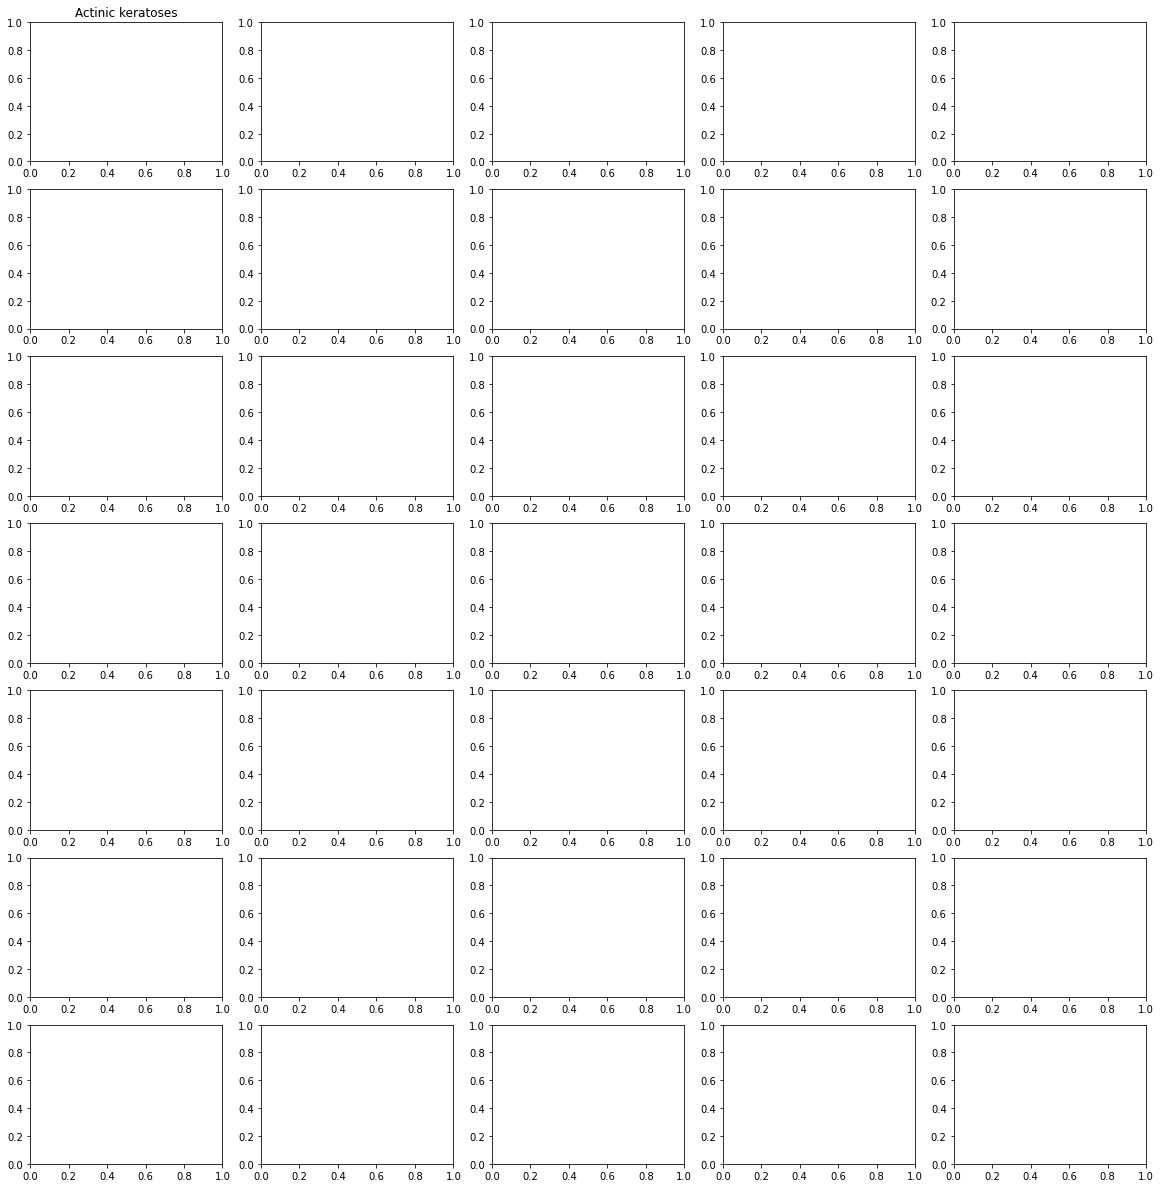

In [ ]:
# Add images to dataframe and output samples of all lasion types 
# (Derived from: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy)

# Add images to dataframe and resize images from 600x450 to 100x75
data['image'] = data['image_path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

# Samples of each lesion type
fig, m_axs = plt.subplots(7, 5, figsize = (4*5, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         data.sort_values(['dx_full']).groupby('dx_full')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(5, random_state=42).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
#fig.savefig(os.path.join(data_folder, 'Lesion Samples.png'), dpi=600)

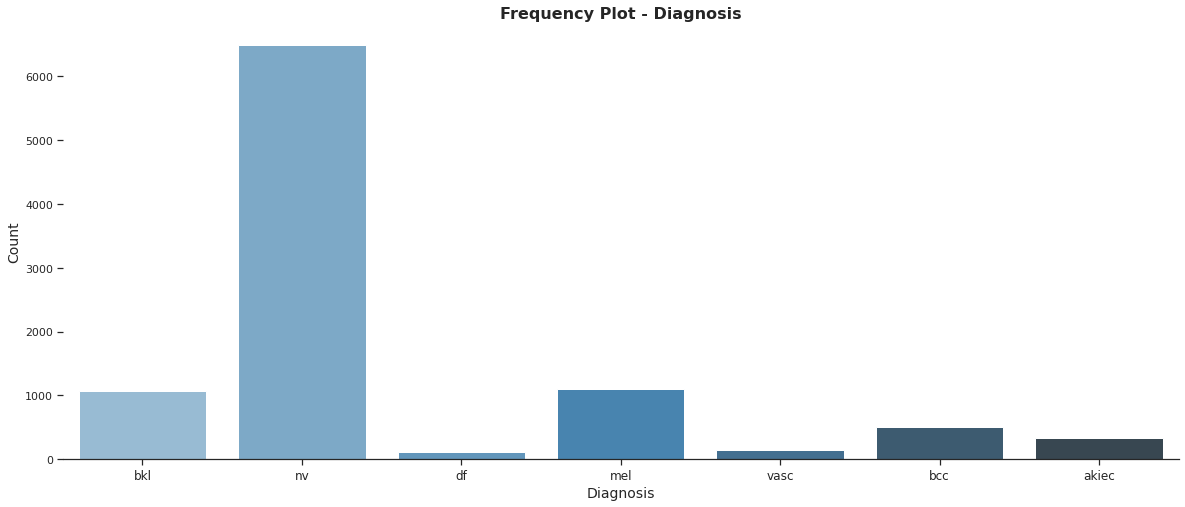

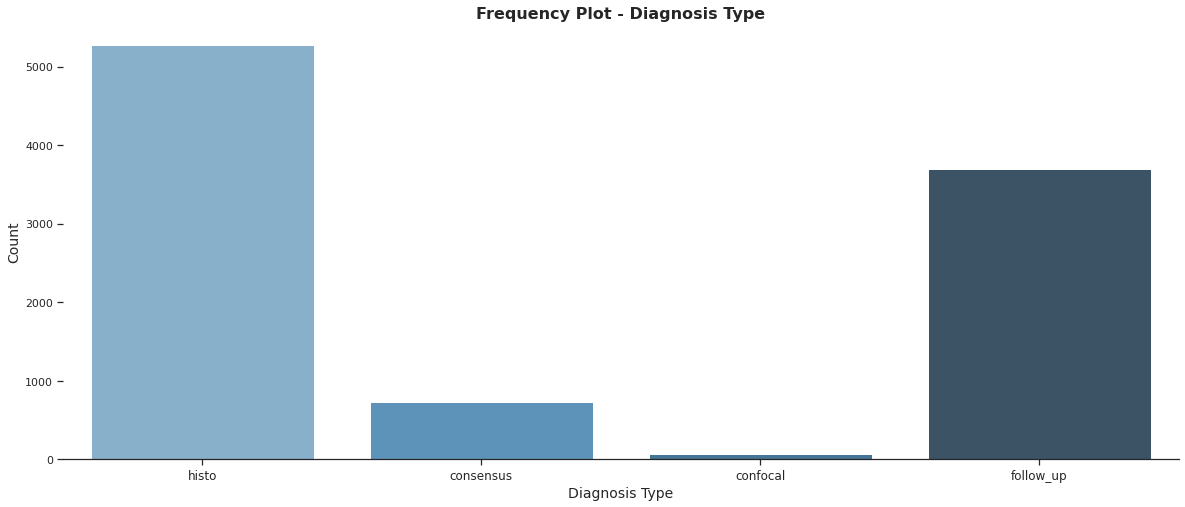

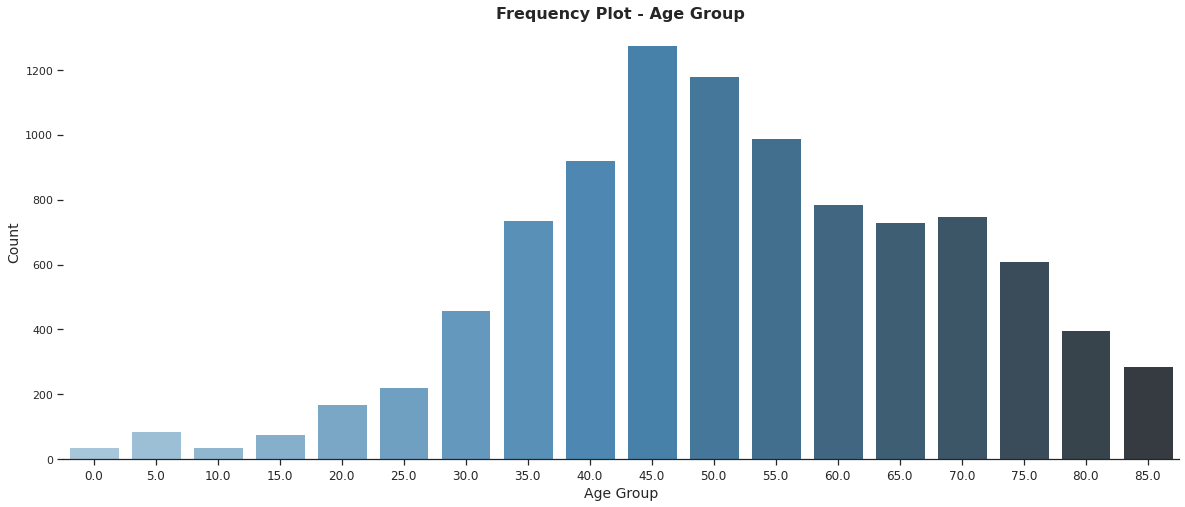

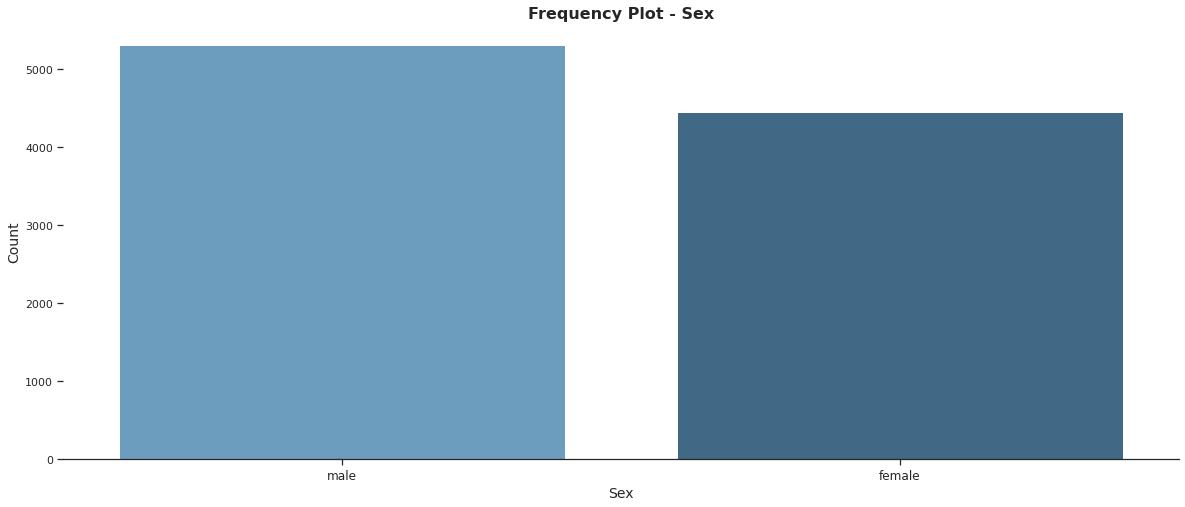

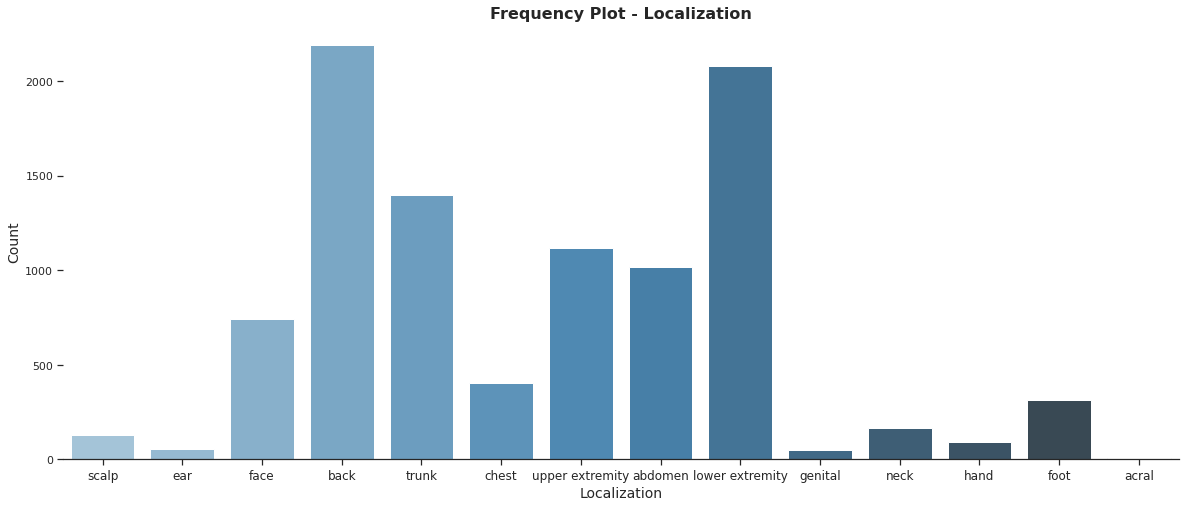

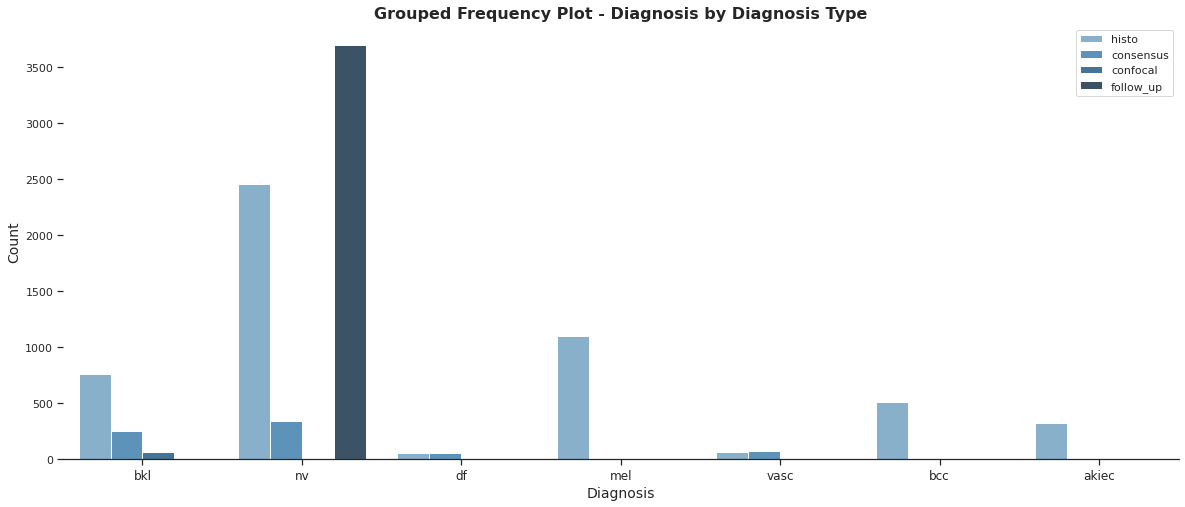

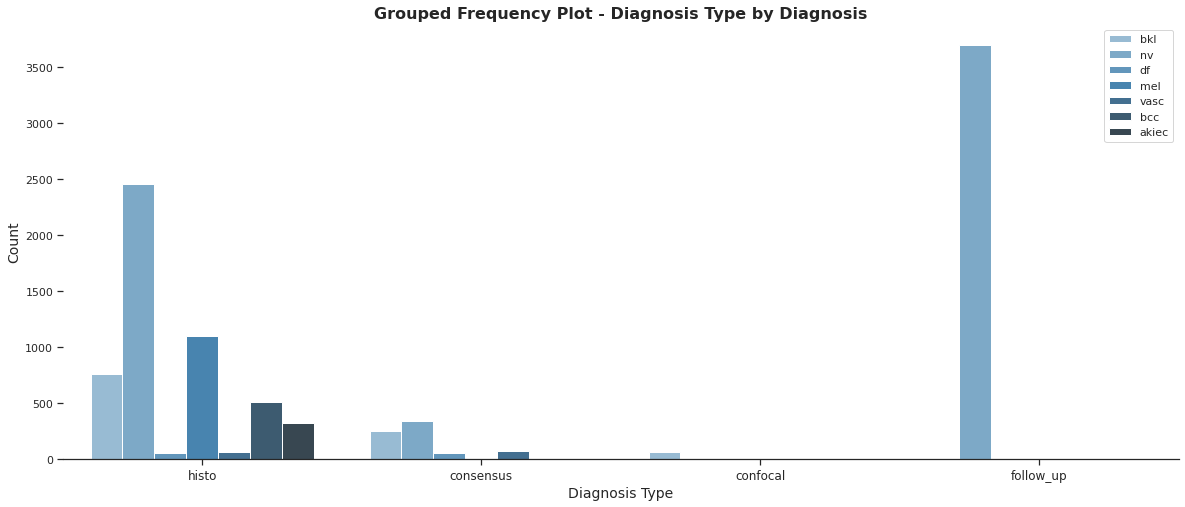

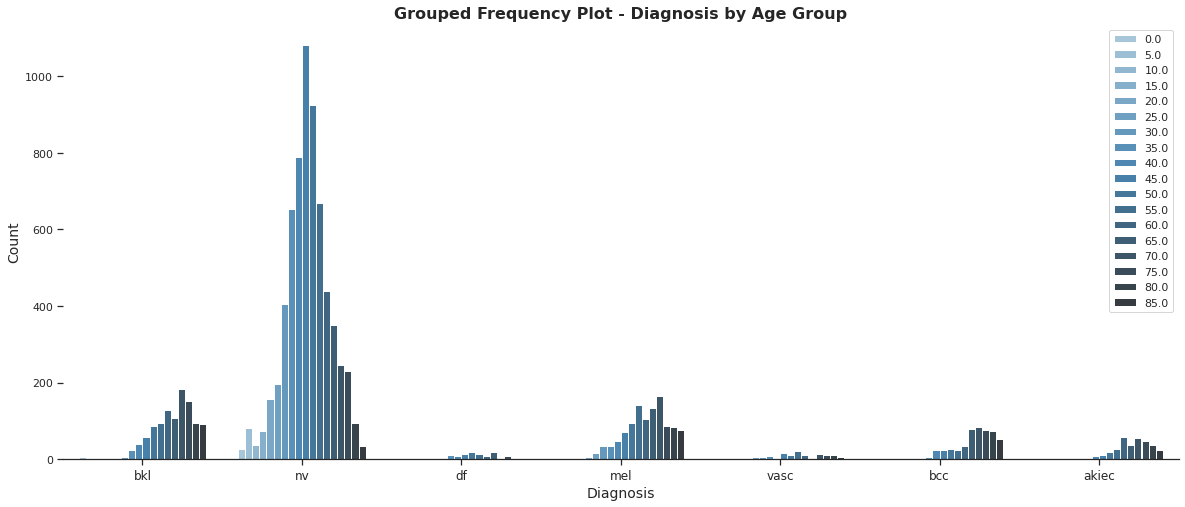

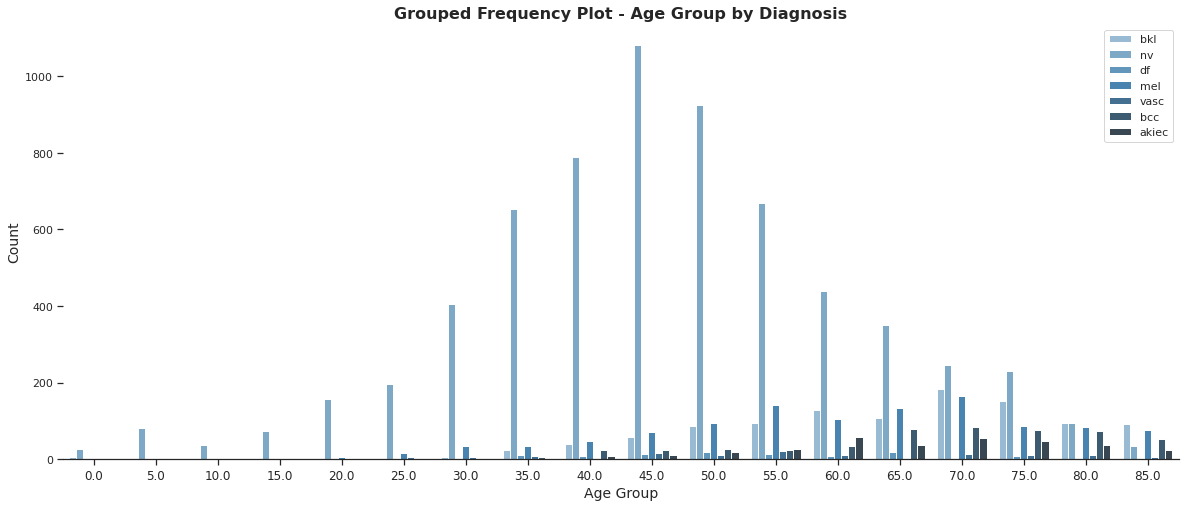

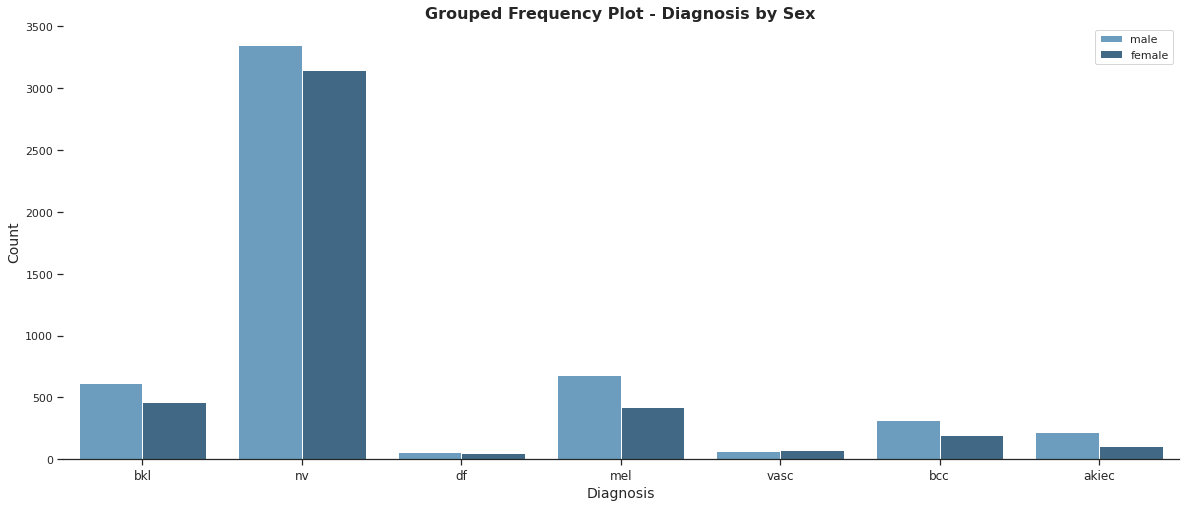

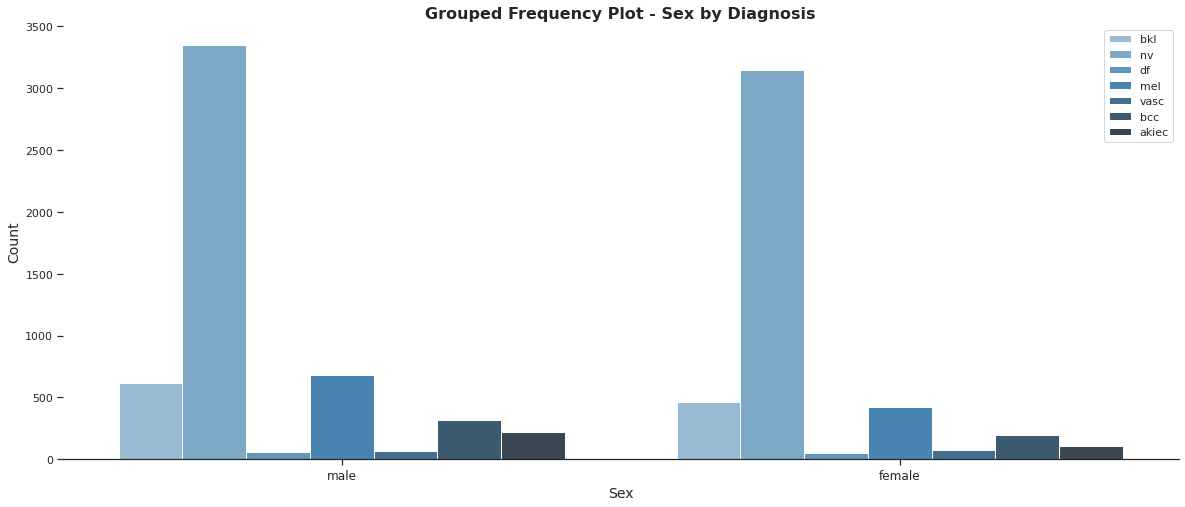

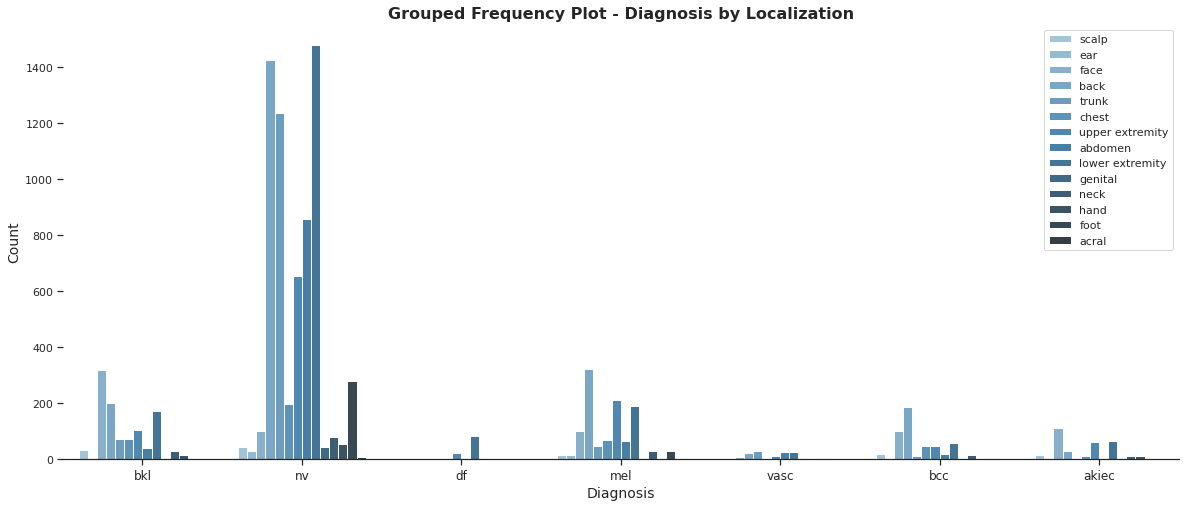

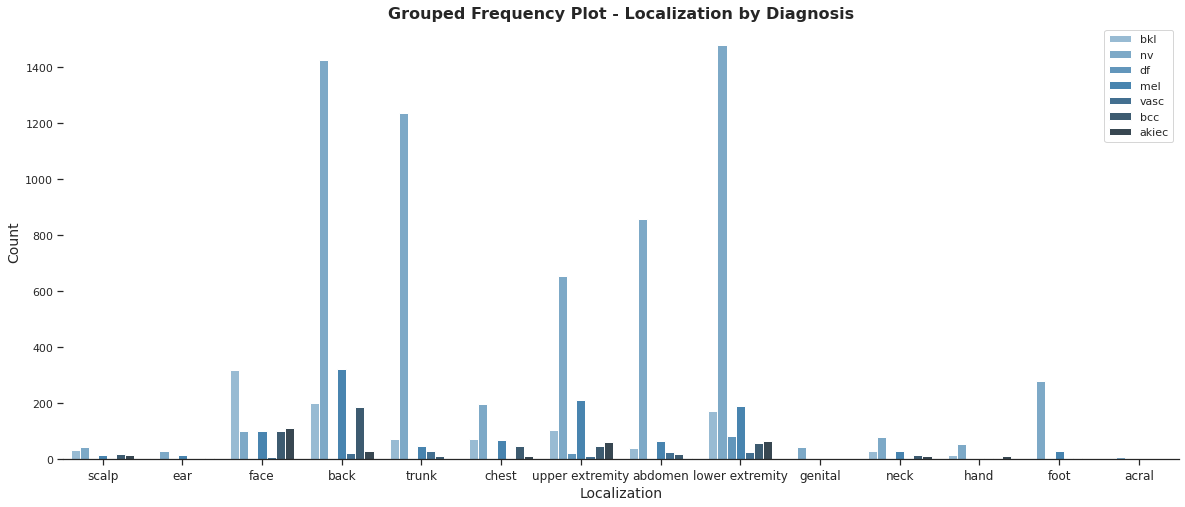

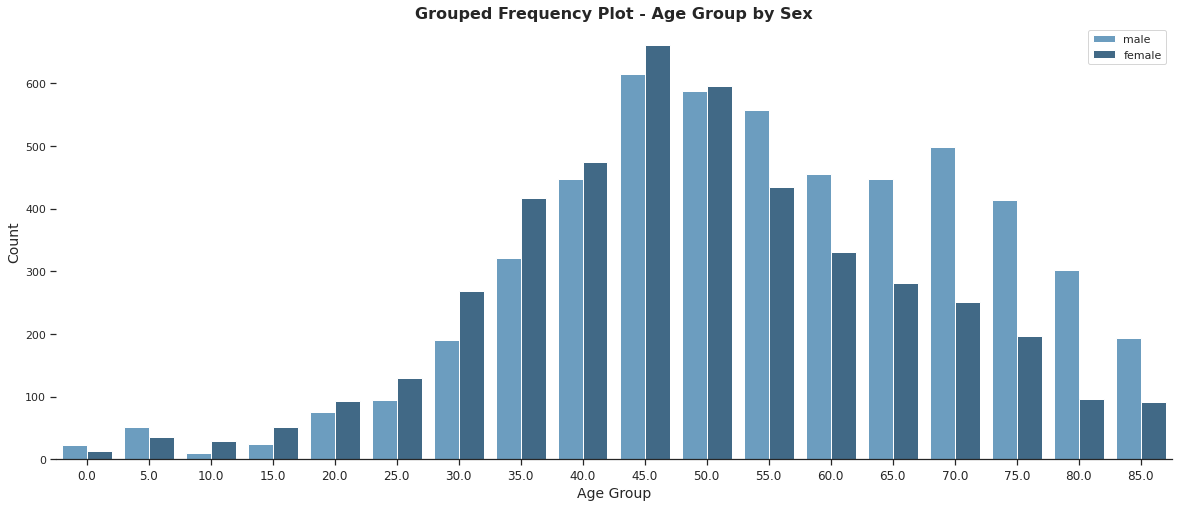

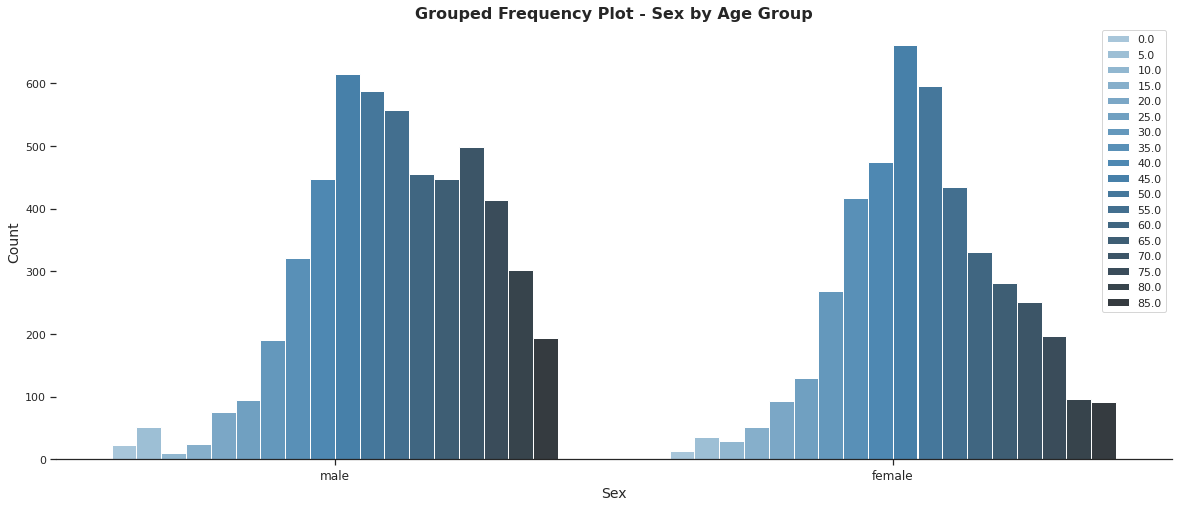

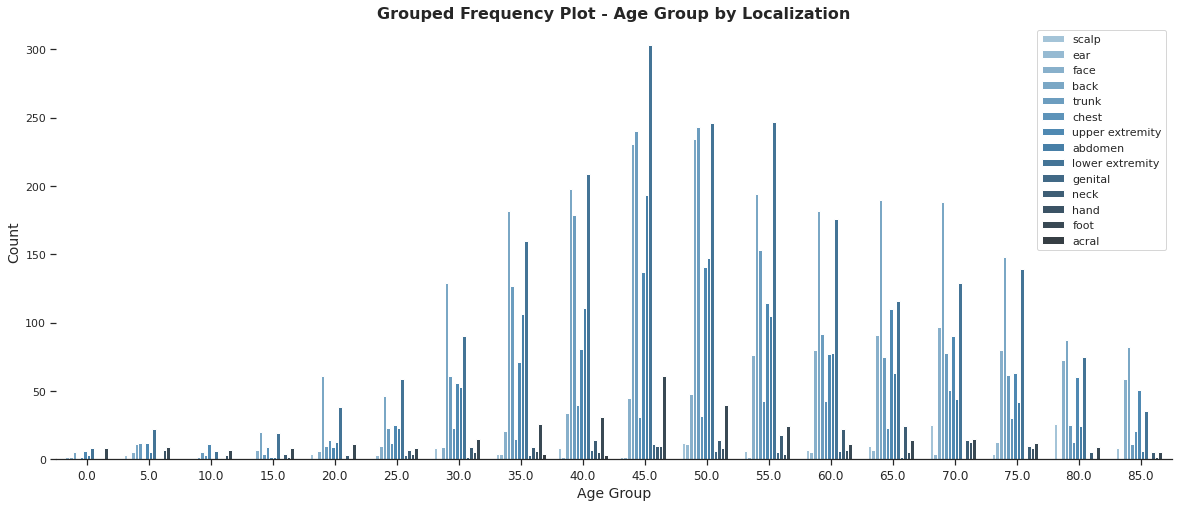

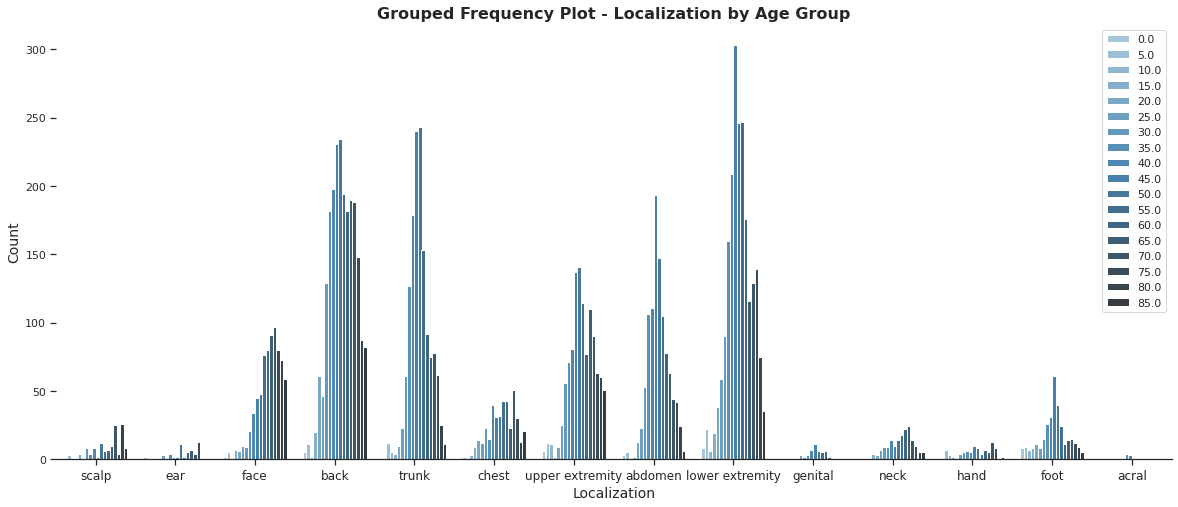

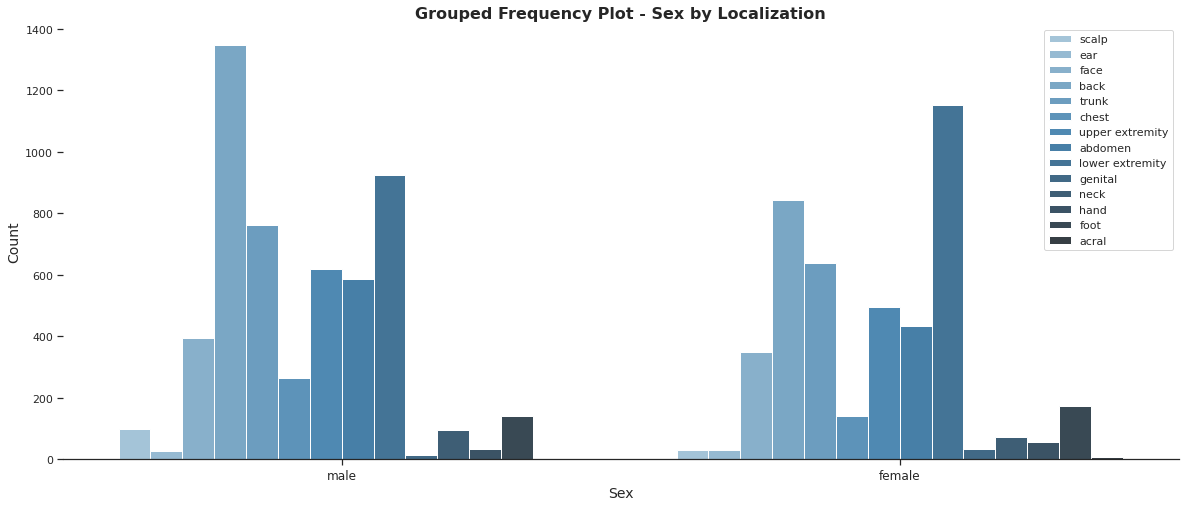

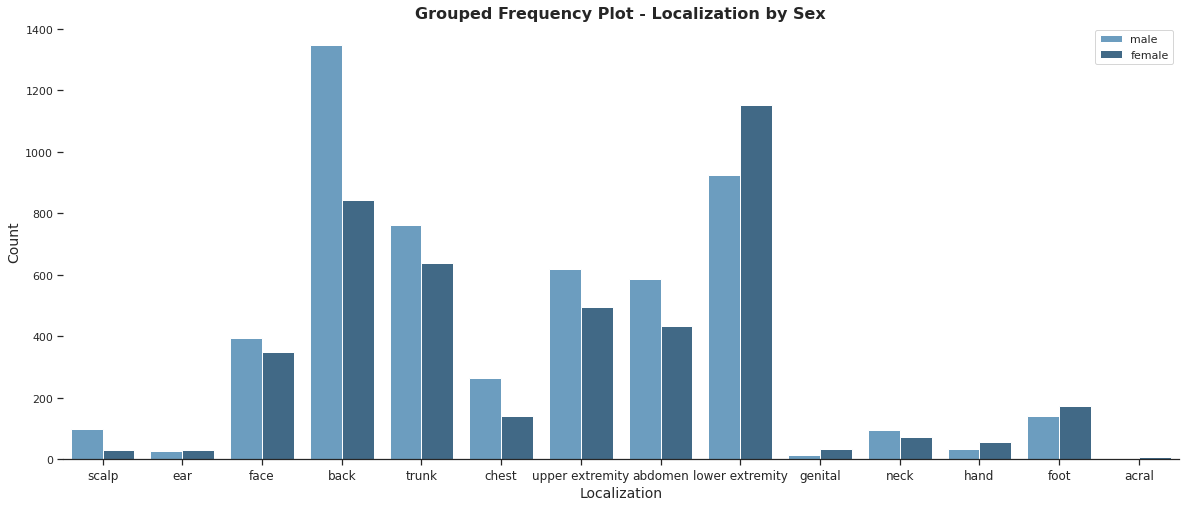

In [ ]:
# Exploratory data analysis - Frequency plots 
# (Derived from: https://www.kaggle.com/jnegrini/ham10000-analysis-and-model-comparison#3.1-CNN)

features = ['dx','dx_type','age','sex','localization']
feature_combos = list(itertools.combinations(features[2:],2))
features_dict = {
    'dx': 'Diagnosis',
    'dx_type': 'Diagnosis Type',
    'age': 'Age Group',
    'sex': 'Sex',
    'localization': 'Localization',}

def frequency_plot(data,feature):
    plt.figure(figsize=(20,8))
    sns.set(style="ticks", font_scale = 1)
    ax = sns.countplot(data=data,x=feature,palette="Blues_d")
    sns.despine(top=True, right=True, left=True, bottom=False)
    plt.xticks(rotation=0,fontsize = 12)
    ax.set_xlabel(features_dict[feature],fontsize = 14)
    ax.set_ylabel('Count',fontsize = 14)
    plt.title("Frequency Plot - " + features_dict[feature], fontsize = 16,weight = 'bold')
    filename = str('Frequency Plot - ' + features_dict[feature] +'.png')
    #plt.savefig(os.path.join(data_folder,filename), dpi=600);
    
for feature in features:
    frequency_plot(data,feature)
    
def grouped_frequency_plot(data,feature1, feature2):
    plt.figure(figsize=(20,8))
    sns.set(style="ticks", font_scale = 1)
    ax = sns.countplot(data=data,x=feature1,palette="Blues_d", hue=feature2)   
    ax.set_xlabel(features_dict[feature1],fontsize = 14)
    ax.set_ylabel('Count',fontsize = 14)
    plt.xticks(rotation=0,fontsize = 12)
    plt.title("Grouped Frequency Plot - " + features_dict[feature1] + ' by ' + features_dict[feature2], fontsize = 16,weight = 'bold');
    plt.legend(loc='upper right');
    sns.despine(top=True, right=True, left=True, bottom=False)
    filename = str('Grouped Frequency Plot - ' + features_dict[feature1] + " and " +features_dict[feature2] +'.png')
    #plt.savefig(os.path.join(data_folder,filename), dpi=600);

for feature in features[1:]:
    grouped_frequency_plot(data,features[0],feature)
    grouped_frequency_plot(data,feature,features[0])

for item in feature_combos:   
    grouped_frequency_plot(data,item[0],item[1])
    grouped_frequency_plot(data,item[1],item[0])

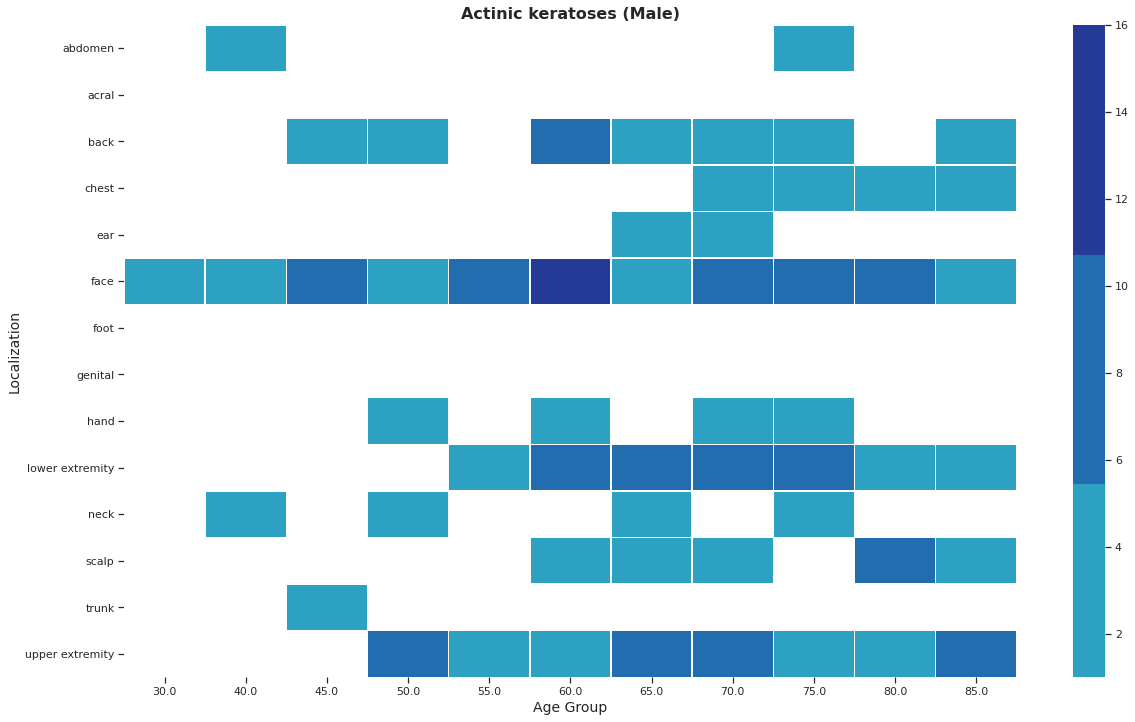

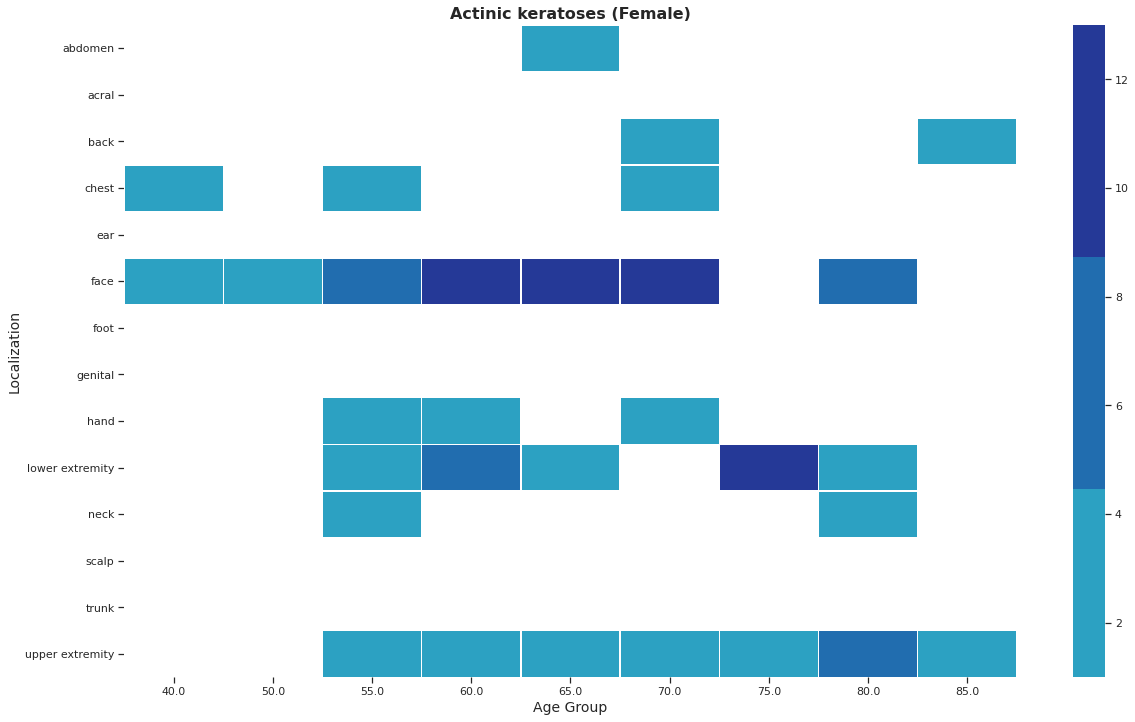

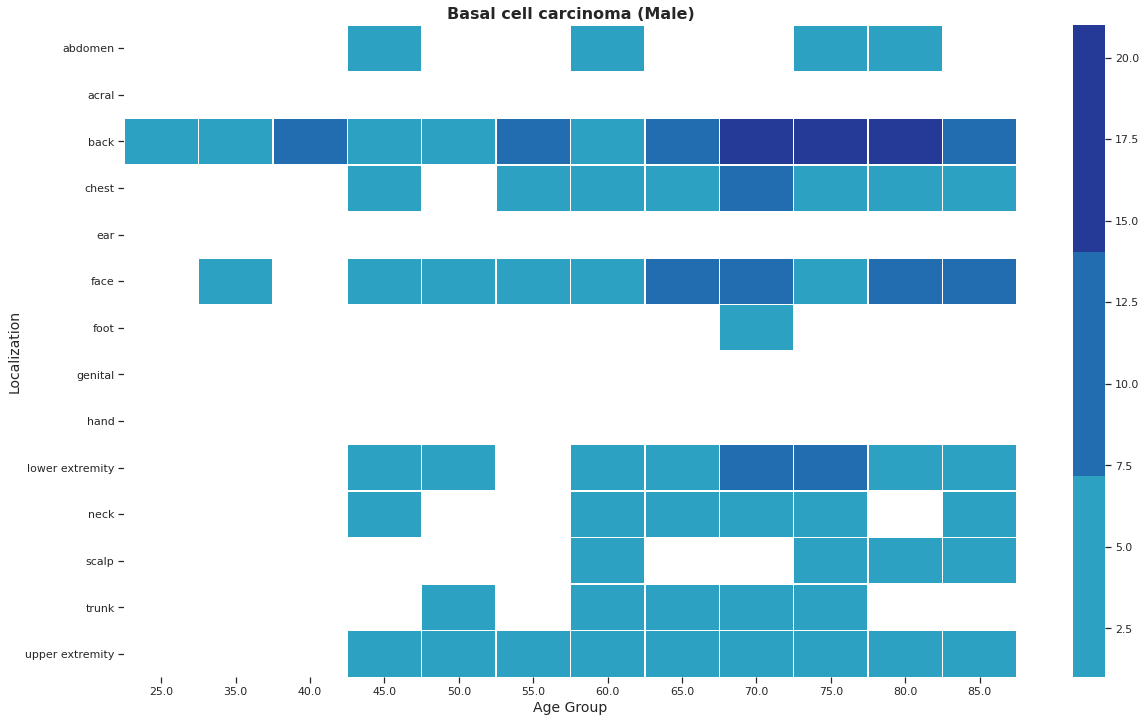

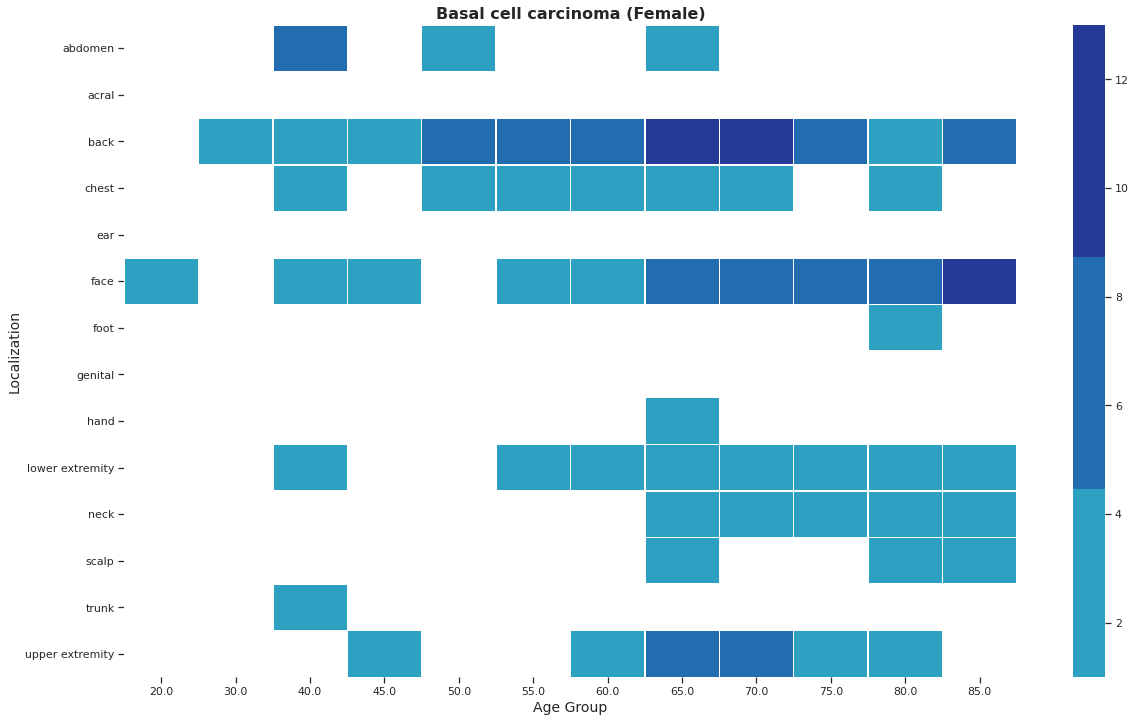

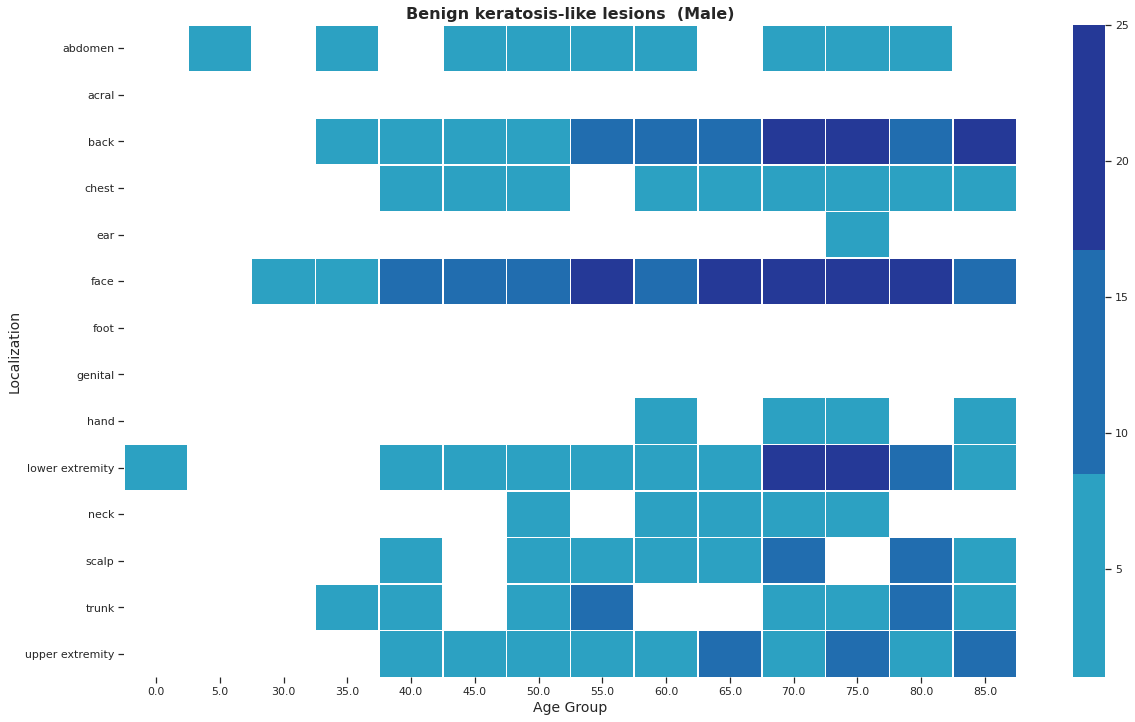

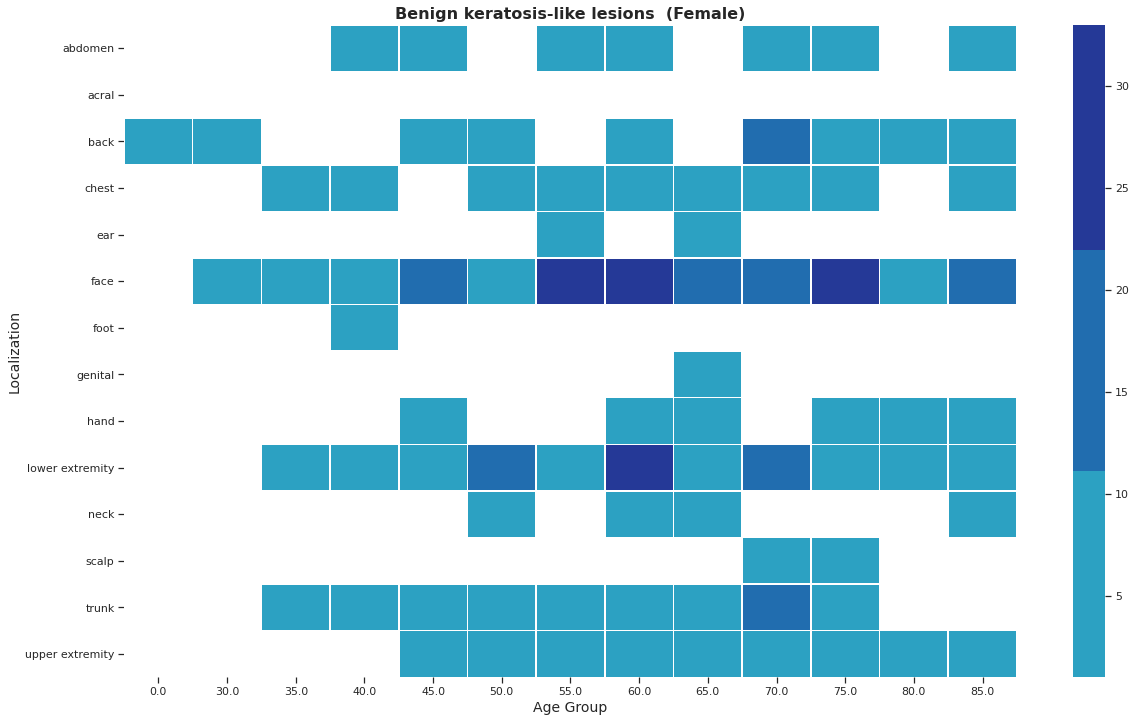

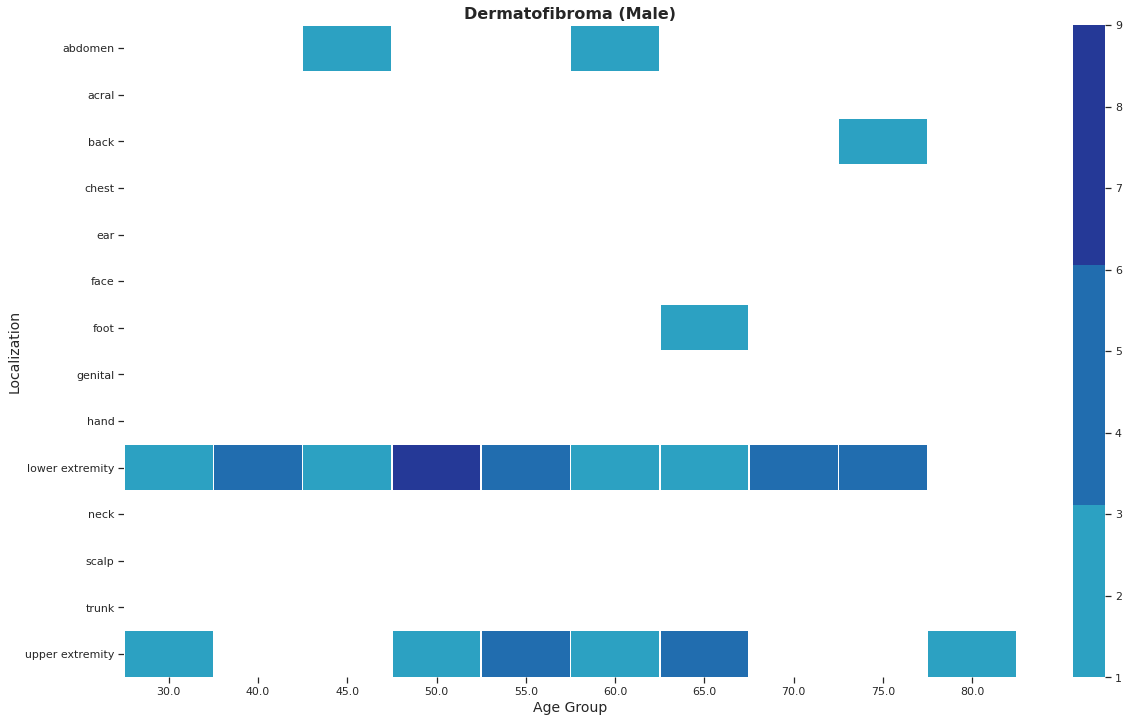

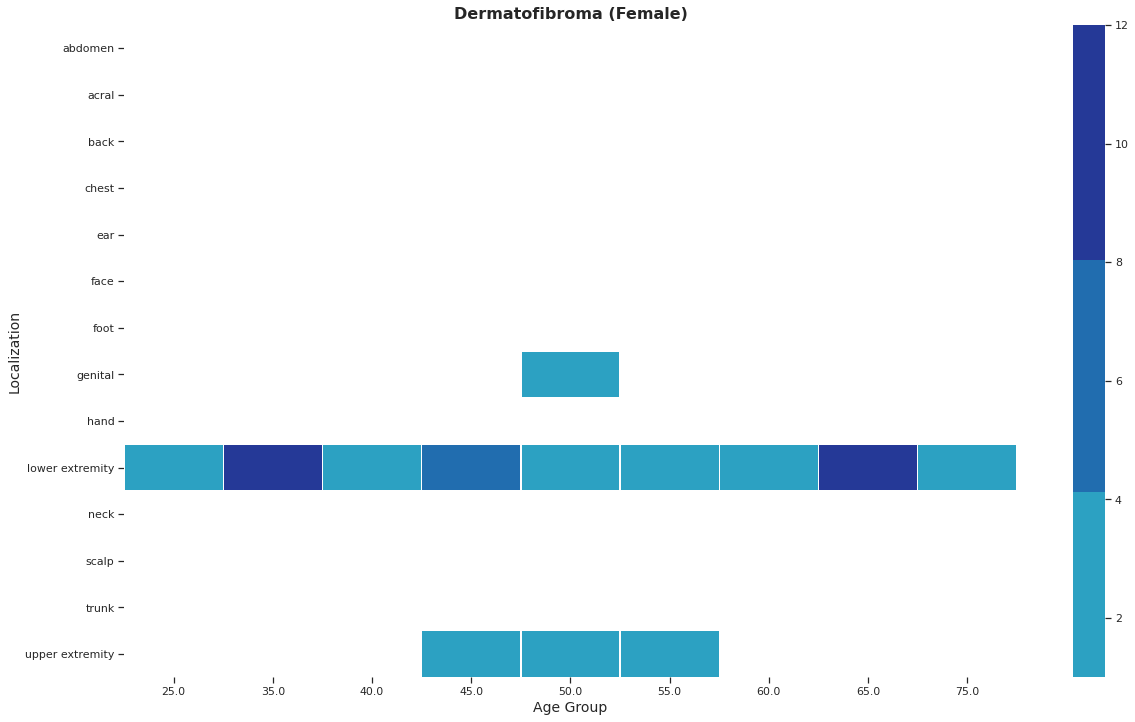

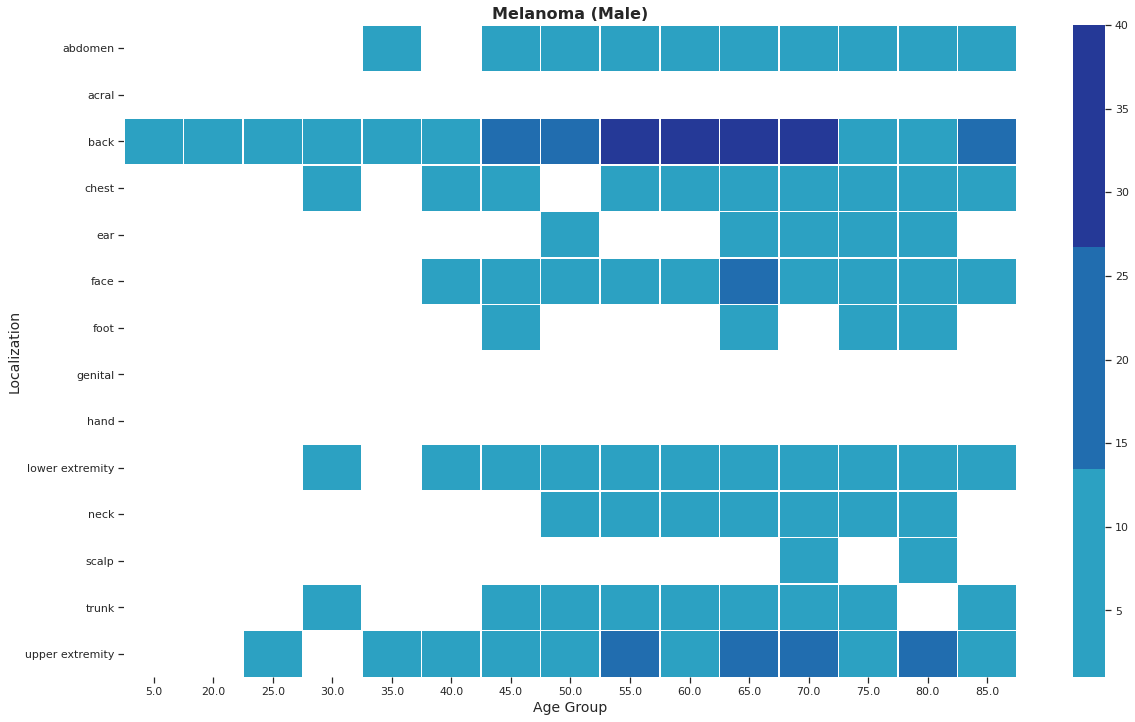

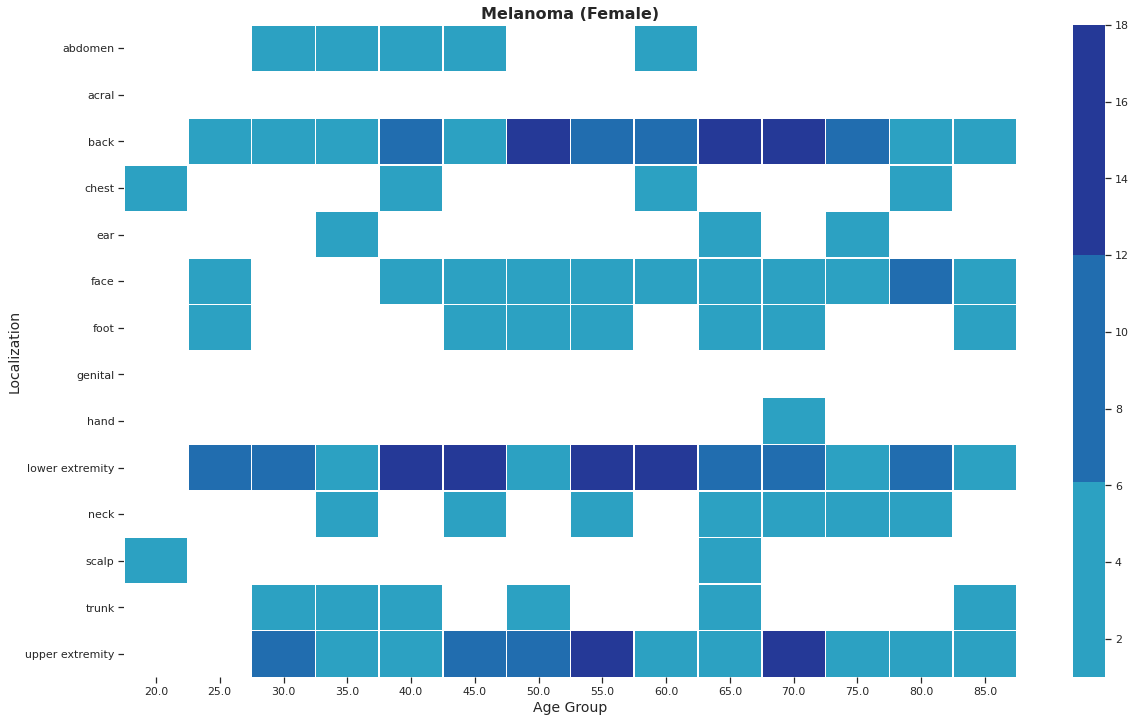

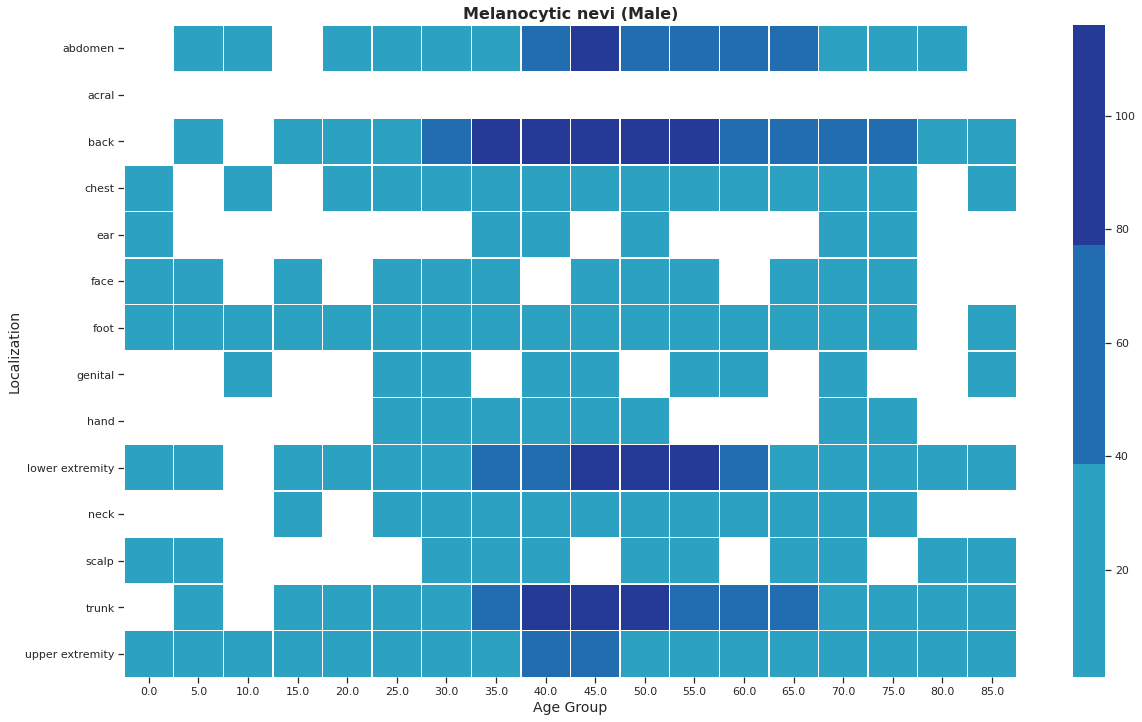

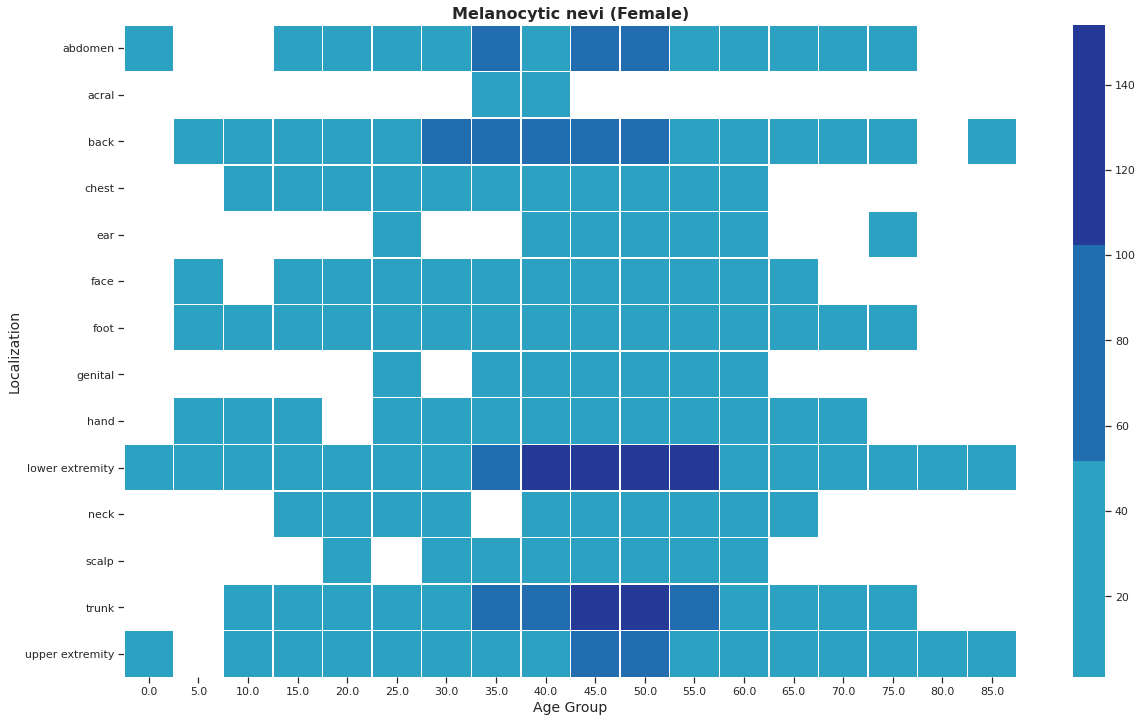

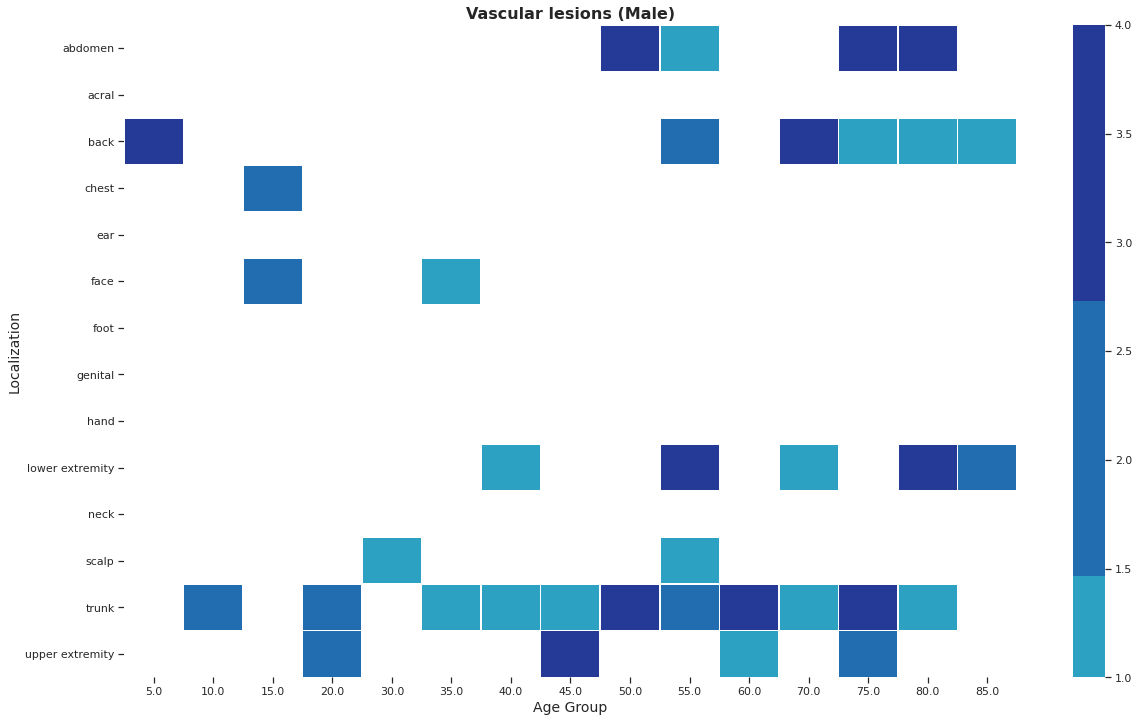

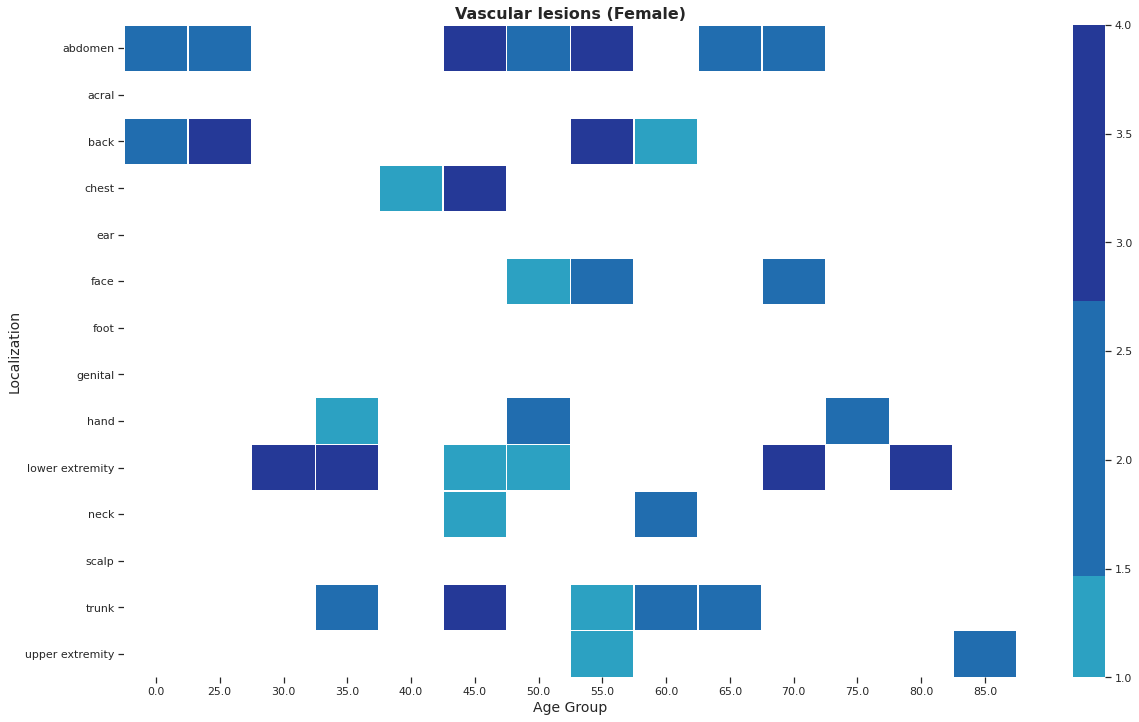

In [ ]:
# Exploratory data analysis - Heatmaps 
# (Derived from: https://www.kaggle.com/jnegrini/ham10000-analysis-and-model-comparison#3.1-CNN)

def heatmap(df, x):   
    localizations_count = data.groupby(['localization']).size().reset_index()  
    y_axis = localizations_count['localization']  
    df = df.pivot(index='localization', columns='age', values=0)
    df = df.reindex(index=y_axis)
    plt.figure(figsize=(20,12))
    ax = sns.heatmap(df, cmap=sns.color_palette("YlGnBu"), center=.2,linewidths=.5)
    ax.set_xlabel(features_dict['age'],fontsize = 14)
    ax.set_ylabel(features_dict['localization'],fontsize = 14)    
    ax.set_title(lesions[lesion] + x ,fontsize = 16,weight = 'bold')
    filename = str('Heatmap ' +lesions[lesion] + x+'.png')
    #plt.savefig(os.path.join(data_folder,filename), dpi=600)
    plt.show()

data_sex_male = data[data["sex"] == 'male']
data_sex_female = data[data["sex"] == 'female']

for lesion in lesions:
    df_male = data_sex_male[data_sex_male['dx'] == lesion].groupby(['age','localization']).size().reset_index()
    df_female = data_sex_female[data_sex_female['dx'] == lesion].groupby(['age','localization']).size().reset_index()
    heatmap(df_male,' (Male)') 
    heatmap(df_female,' (Female)')

In [ ]:
# Save dataframe as pickle to be used in other Notebooks
pd.to_pickle(data, os.path.join(data_folder, 'data.pkl'))

NameError: ignored